In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks 
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP

plt.rcParams['figure.facecolor'] = 'white'

In [3]:
from loss.nll_loss import NLLRegLoss
from torch.nn import functional as F
from model.ensemble import MLPEnsemble

def nll_postprocessing(x):
    return torch.cat([x[:, [0]], F.softplus(x[:, [1]])], dim=1)

def nll_mean_only(x):
    return x[:, 0]

In [4]:
import torch
torch.cuda.set_device(1)

In [5]:

config = {
    'nn_runs': 200,
    'verbose': False,
    'use_cache': False, 
    'layers': [1, 128, 128, 64, 1],
    'nll_layers': [1, 128, 128, 64, 2],
    'patience': 10,
    'dropout_train': 0.2,
    'dropout_uq': 0.5
}

### Visualizing on toy data

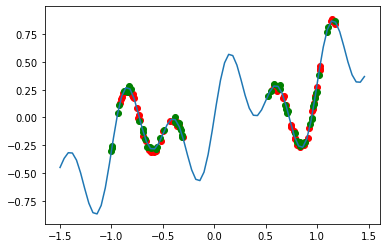

In [6]:
# Generate dataset
# dataset = 'qubic'
dataset = 'sin'
 
if dataset == 'qubic':
    x_train, y_train = ToyQubicData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToyQubicData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToyQubicData().dataset('ground_truth')
else:
    x_train, y_train = ToySinData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToySinData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToySinData().dataset('ground_truth')
    
plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')

In [7]:
models = {}

### RMSE

Epoch [100/10000], Loss: 0.0074, Validation loss: 0.0050
Epoch [200/10000], Loss: 0.0037, Validation loss: 0.0026
Epoch [300/10000], Loss: 0.0037, Validation loss: 0.0027
Epoch [400/10000], Loss: 0.0018, Validation loss: 0.0034
Epoch [500/10000], Loss: 0.0032, Validation loss: 0.0014
Epoch [600/10000], Loss: 0.0054, Validation loss: 0.0031
Epoch [700/10000], Loss: 0.0100, Validation loss: 0.0049
Epoch [800/10000], Loss: 0.0076, Validation loss: 0.0034
Epoch [900/10000], Loss: 0.0001, Validation loss: 0.0020
Epoch [1000/10000], Loss: 0.0030, Validation loss: 0.0025
Epoch [1100/10000], Loss: 0.0012, Validation loss: 0.0029
Epoch [1200/10000], Loss: 0.0034, Validation loss: 0.0024
Epoch [1300/10000], Loss: 0.0031, Validation loss: 0.0029
Epoch [1400/10000], Loss: 0.0003, Validation loss: 0.0053
Epoch [1500/10000], Loss: 0.0032, Validation loss: 0.0036


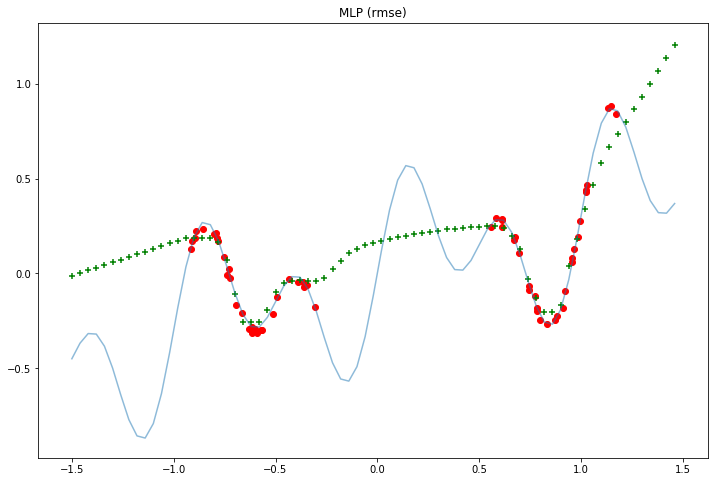

In [8]:
# Train model
models['mlp_rmse'] = MLP(config['layers'])
models['mlp_rmse'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['mlp_rmse'](x_true).cpu().numpy()

plt.figure(figsize=(12, 8))
plt.title('MLP (rmse)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

Fit [0/5] model:
Epoch [100/10000], Loss: 0.0086, Validation loss: 0.0061
Epoch [200/10000], Loss: 0.0027, Validation loss: 0.0053
Epoch [300/10000], Loss: 0.0070, Validation loss: 0.0031
Epoch [400/10000], Loss: 0.0016, Validation loss: 0.0037
Epoch [500/10000], Loss: 0.0146, Validation loss: 0.0037
Epoch [600/10000], Loss: 0.0073, Validation loss: 0.0022
Epoch [700/10000], Loss: 0.0061, Validation loss: 0.0031
Epoch [800/10000], Loss: 0.0061, Validation loss: 0.0035
Epoch [900/10000], Loss: 0.0020, Validation loss: 0.0068
Epoch [1000/10000], Loss: 0.0049, Validation loss: 0.0025
Epoch [1100/10000], Loss: 0.0126, Validation loss: 0.0056
Epoch [1200/10000], Loss: 0.0031, Validation loss: 0.0024
Epoch [1300/10000], Loss: 0.0009, Validation loss: 0.0033
Epoch [1400/10000], Loss: 0.0009, Validation loss: 0.0027
Epoch [1500/10000], Loss: 0.0007, Validation loss: 0.0026
Epoch [1600/10000], Loss: 0.0012, Validation loss: 0.0039
Fit [1/5] model:
Epoch [100/10000], Loss: 0.0075, Validation los

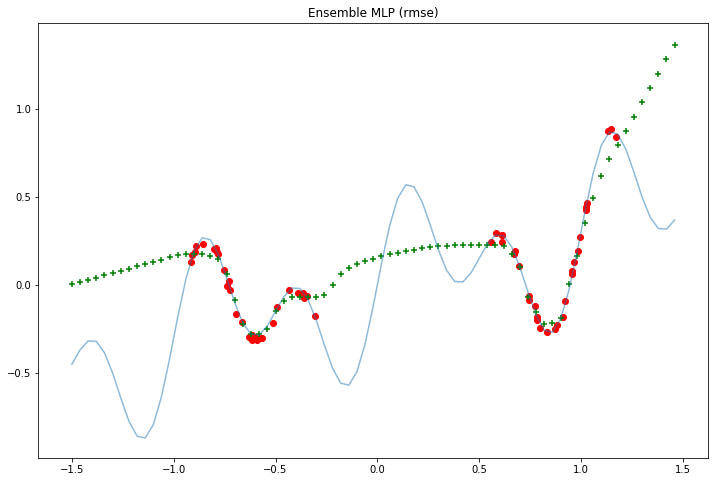

In [9]:
# Train model

models['ensemble_rmse'] = MLPEnsemble(config['layers'], n_models=5, reduction='mean')
models['ensemble_rmse'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['ensemble_rmse'](x_true).cpu().numpy()

plt.figure(figsize=(12, 8))
plt.title('Ensemble MLP (rmse)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

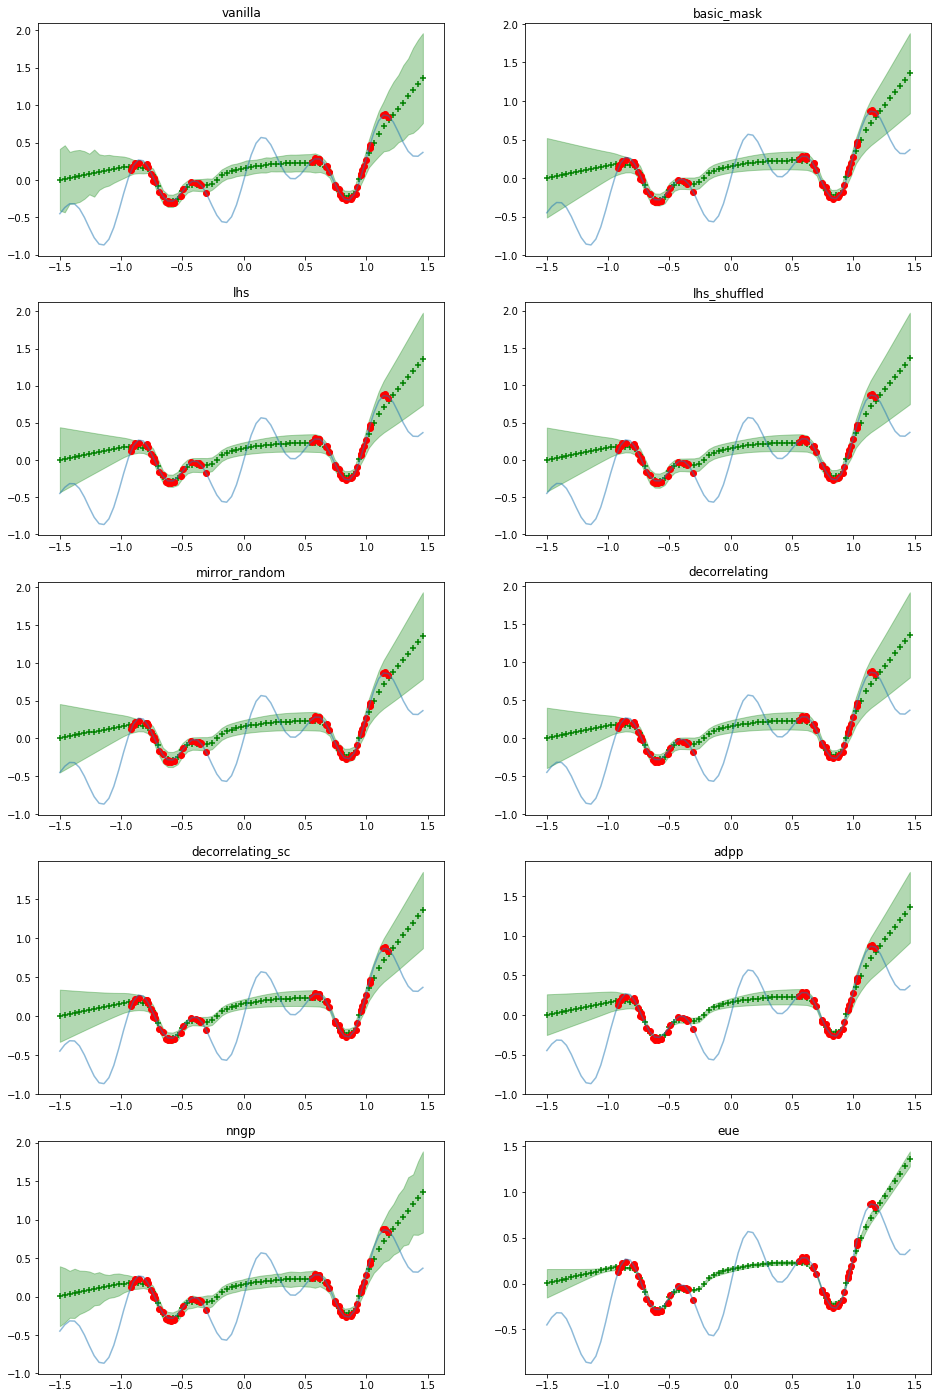

In [25]:
# Evaluate UQ and plot the results
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')

masks = build_masks(nn_runs = config['nn_runs'])
model = models['mlp_rmse']

for i, (name, mask) in enumerate(masks.items()):
    try:
        if hasattr(mask, 'reset'):
            mask.reset()
        estimator = build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])

        estimations = estimator.estimate(x_true)
        plt.subplot(6, 2, i+1)
        make_uq_graph(name, estimations)
    except:
        continue

        
nngp = build_estimator('nngp', model, nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = nngp.estimate(x_true, x_train)
plt.subplot(6, 2, len(masks)+1)
make_uq_graph('nngp', estimations)

eue = build_estimator('eue', models['ensemble_rmse'])
estimations = eue.estimate(x_true)
plt.subplot(6, 2, len(masks)+2)
make_uq_graph('eue', estimations)

### NLL

Epoch [100/10000], Loss: -1.6518, Validation loss: -1.3104
Epoch [200/10000], Loss: -1.7648, Validation loss: -1.6685
Epoch [300/10000], Loss: -1.6754, Validation loss: -1.8434
Epoch [400/10000], Loss: -1.4889, Validation loss: -1.9803
Epoch [500/10000], Loss: -1.7107, Validation loss: -1.8352
Epoch [600/10000], Loss: -1.7551, Validation loss: -1.9530
Epoch [700/10000], Loss: -1.3974, Validation loss: -1.8600
Epoch [800/10000], Loss: -1.5592, Validation loss: -2.2247
Epoch [900/10000], Loss: -2.1207, Validation loss: -2.0309
Epoch [1000/10000], Loss: -1.7560, Validation loss: -2.0071
Epoch [1100/10000], Loss: -0.9660, Validation loss: -1.9967
Epoch [1200/10000], Loss: -2.0258, Validation loss: -2.0411
Epoch [1300/10000], Loss: -1.5367, Validation loss: -2.0870
Epoch [1400/10000], Loss: -1.9540, Validation loss: -2.0802
Epoch [1500/10000], Loss: -1.4804, Validation loss: -2.1411
Epoch [1600/10000], Loss: -1.9559, Validation loss: -2.2569
Epoch [1700/10000], Loss: -2.0704, Validation los

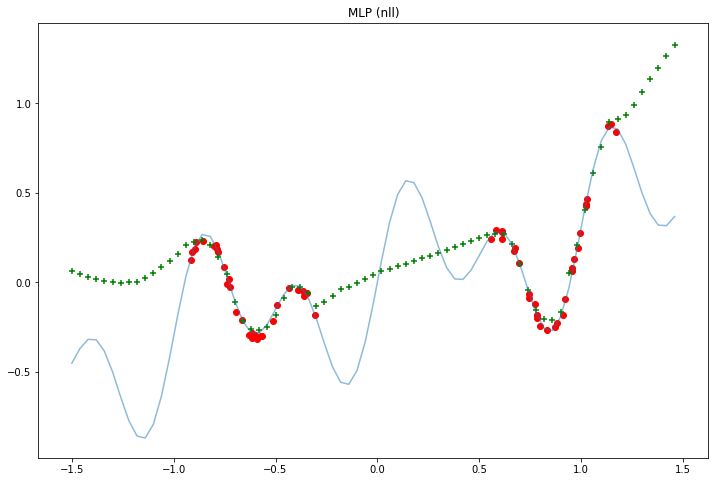

In [26]:
# Train model
models['mlp_nll'] = MLP(config['nll_layers'], loss=NLLRegLoss,
                        postprocessing=nll_postprocessing)
models['mlp_nll'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['mlp_nll'](x_true).cpu().numpy()[:, 0]

plt.figure(figsize=(12, 8))
plt.title('MLP (nll)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

In [ ]:
models['ensemble_nll'] = MLPEnsemble(config['nll_layers'], reduction='nll',
                                     n_models=5, loss=NLLRegLoss,
                                     postprocessing=nll_postprocessing )
models['ensemble_nll'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])

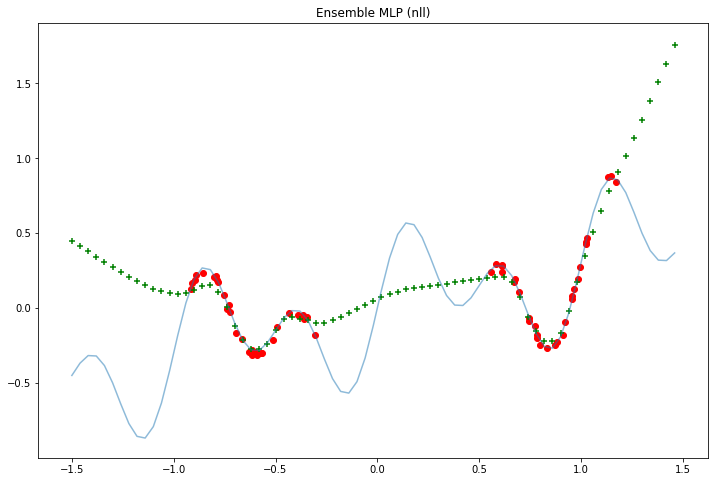

In [30]:
# Train model

y_pred = models['ensemble_nll'](x_true).cpu().numpy()[0, :]

plt.figure(figsize=(12, 8))
plt.title('Ensemble MLP (nll)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

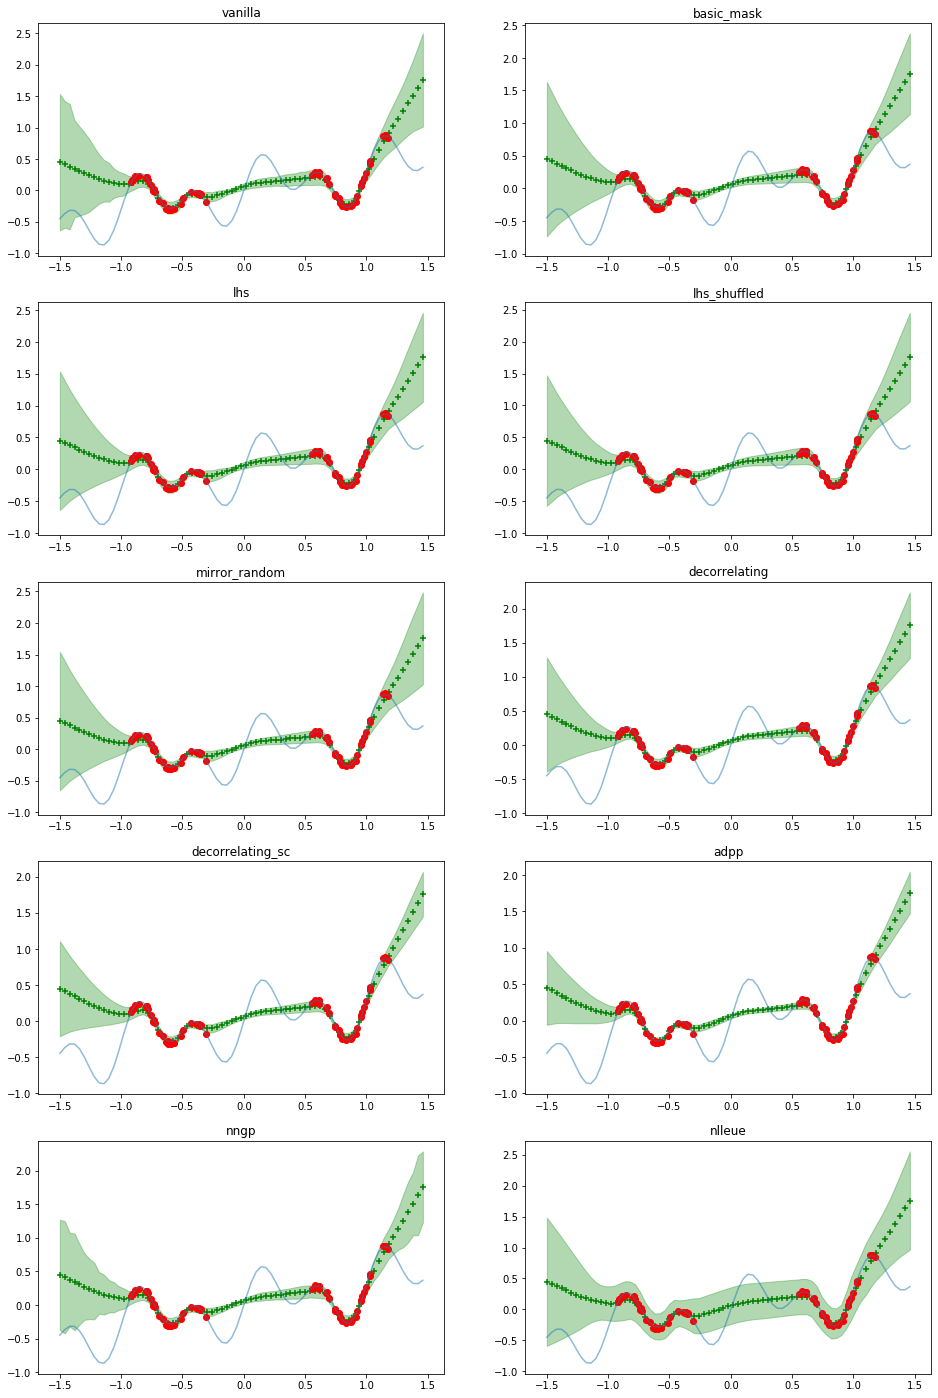

In [35]:
# Evaluate UQ and plot the results
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')

masks = build_masks(nn_runs = config['nn_runs'])
model = models['mlp_nll']
model.postprocessing = nll_mean_only

for i, (name, mask) in enumerate(masks.items()):
    try:
        if hasattr(mask, 'reset'):
            mask.reset()
        estimator = build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])

        estimations = estimator.estimate(x_true)
        plt.subplot(6, 2, i+1)
        make_uq_graph(name, estimations)
    except:
        continue

        
nngp = build_estimator('nngp', model, nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = nngp.estimate(x_true, x_train)
plt.subplot(6, 2, len(masks)+1)
make_uq_graph('nngp', estimations)


eue = build_estimator('nlleue', models['ensemble_nll'])
estimations = eue.estimate(x_true)
plt.subplot(6, 2, len(masks)+2)
make_uq_graph('nlleue', estimations)